# Lab 11: Self-Organizing Maps 

Learning Objectives:

- Understand SOM Fundamentals
- Train and Evaluate SOMs
- Analyze SOM Visualizations
- Implement Two-Stage Clustering

## Imports and Data Loading

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mpl_colors
from matplotlib.colors import Normalize

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering

# Self-Organizing Maps
from minisom import MiniSom

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Visualization styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Helper functions from Labs 09-12 for R² calculation

def get_ss(df, features):

    return np.sum(df[features].var() * (df[features].count() - 1))


def get_ssw(df, features, label_col):

    return df.groupby(label_col)[features].apply(
        lambda x: get_ss(x, features)
    ).sum()


def get_ssb(df, features, label_col):

    sst = get_ss(df, features)
    ssw = get_ssw(df, features, label_col)
    return sst - ssw


def get_rsq(df, features, label_col):

    sst = get_ss(df, features)
    ssw = get_ssw(df, features, label_col)
    return 1 - (ssw / sst)



In [3]:
# Load preprocessed customer data
df = pd.read_csv('../data/data_preprocessed.csv')

df.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Married,oh_status_Single,oh_status_Together,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
# Metric features for SOM training and clustering (10 total)
metric_features = [
    'income',           # Annual income
    'frq',              # Purchase frequency
    'rcn',              # Recency (days since last purchase)
    'clothes',          # Spending on clothing
    'kitchen',          # Kitchen items spending
    'small_appliances', # Small appliances spending
    'toys',             # Toy purchases
    'house_keeping',    # Housekeeping products spending
    'per_net_purchase', # Average purchase value
    'spent_online'      # Online channel spending
]

# Categorical variables (for profiling, not clustering)
categorical_features = ['education', 'status', 'gender']


# SOM Fundamentals

Observations: 

<div align="center"> 

| Data Point | Income | Age | Toys | Kitchen |
|:----------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| $\mathbf{x}_1$ | 0.9 | 0.1 | 0.1 | 0.9 |
| $\mathbf{x}_2$ | 0.8 | 0.2 | 0.2 | 0.8 |
| $\mathbf{x}_3$ | 0.1 | 0.9 | 0.9 | 0.1 |
| $\mathbf{x}_4$ | 0.2 | 0.8 | 0.8 | 0.2 |

 </div>

<br>

Units: 
<div align="center"> 

| Neuron | $w_1$ | $w_2$ | $w_3$ | $w_4$ |
|:------:|:-----:|:-----:|:-----:|:-----:|
| $\mathbf{w}_1$ | 0.70 | 0.30 | 0.30 | 0.70 |
| $\mathbf{w}_2$ | 0.30 | 0.70 | 0.70 | 0.30 |

</div>

Concepts: 
- Best Matching Unit (BMU): closest weight vector 
- Update of weights based of BMU and neighborhood (neighborhood function)
   - Unfolding phase: Large neighborhood radius, spread units across input space
   - Fine-tuning phase: Small neighborhood radius, reduce quantization error

Characteristics: 
- Visualization high-D data in a 2D grid: similarity relationships preserved 
- Capable of finding the global optimum (theoretically if LR -> 0)
- Grid shape need to be set a priori 
- Results depend on the initializaiton 
- Fitting a SOM can be computationally expensive 

**Video**

https://www.youtube.com/watch?v=k7DK5fnJH94

## Clustering different colors with SOM 

- 1000 colors 
- 3 features (R,G,B) each 

In [5]:
# Create RGB color dataset (random samples from color space)
n_colors = 1000
rgb_data = np.random.randint(0, 256, size=(n_colors, 3))


In [6]:
rgb_df = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])
rgb_df

,R,G,B
0,102,179,92
1,14,106,71
2,188,20,102
3,121,210,214
4,74,202,87
...,...,...,...
995,101,217,10
996,98,199,109
997,205,73,193
998,173,8,2


In [7]:
# Normalize to 0-1 range for SOM
rgb_normalized = rgb_data / 255.0


In [8]:
som_rgb = MiniSom(x=10, y=10,                   # Size of SOM grid  
                  input_len=3,                  # Number of features (RGB)
                  sigma=1.5,                    # Neighborhood radius
                  learning_rate=0.5,            # Learning rate 
                  neighborhood_function='gaussian',  # Neighborhood function
                  topology='hexagonal',          # N_neighborhood topology
                  random_seed=42
                  )

In [9]:
som_rgb.random_weights_init(rgb_normalized)

init_units = som_rgb.get_weights()   # weights after initialization
init_units.shape

(10, 10, 3)

#### How many total units we have ? 

In [10]:
print(init_units[0,0])
print(init_units[1, 0])

[0.6        0.49411765 0.00784314]
[0.23921569 0.3254902  0.43529412]


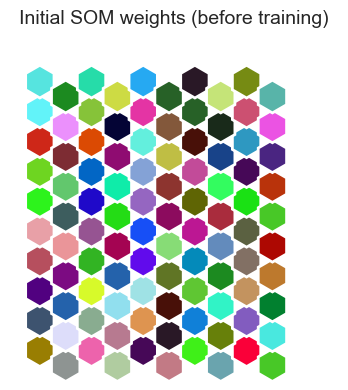

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
init_weights = som_rgb.get_weights()   # weights after initialization

for i in range(10):
    for j in range(10):
        color = np.clip(init_weights[i, j], 0, 1)
        
        hex_coord = som_rgb.convert_map_to_euclidean((i, j))
        center = [hex_coord[1], hex_coord[0]]
        
        hexagon = RegularPolygon(
            center, numVertices=6, radius=0.95/np.sqrt(3),
            facecolor=color, edgecolor='white', linewidth=2
        )
        ax.add_patch(hexagon)

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Initial SOM weights (before training)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [12]:
som_rgb.train_batch(
    rgb_normalized, 
    num_iteration=1000, 
    verbose=False
    )

In [13]:
weights_rgb = som_rgb.get_weights()
weights_rgb.shape

(10, 10, 3)

In [14]:
print(weights_rgb[0,0])
print(weights_rgb[0, 1])


[0.84614964 0.85187759 0.24713979]
[0.8993352  0.73556749 0.2914214 ]


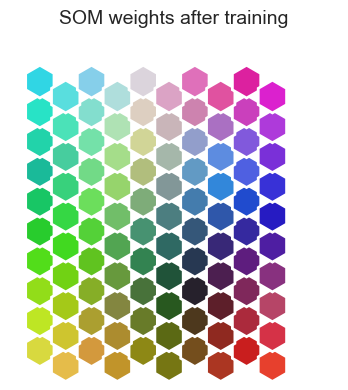

In [15]:
# Visualize RGB SOM as colored grid
fig, ax = plt.subplots(figsize=(4, 4))

for i in range(10):
    for j in range(10):
        # Get RGB color for this unit (ensure values in 0-1 range)
        color = np.clip(weights_rgb[i, j], 0, 1)
        
        # Convert grid to hexagonal coordinates
        hex_coord = som_rgb.convert_map_to_euclidean((i, j))
        center = [hex_coord[1], hex_coord[0]]
        
        # Draw hexagon with learned color
        hexagon = RegularPolygon(
            center, numVertices=6, radius=0.95/np.sqrt(3),
            facecolor=color, edgecolor='white', linewidth=2
        )
        ax.add_patch(hexagon)

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('SOM weights after training', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

.

.

.

Another [example](https://claude.ai/public/artifacts/c21f3cf5-9828-4d27-aa40-be8f051c458d) of clustering an image using SOMs 
- Clustering an image of 20x10 pixels (20, 10, 3) 
- Using a 5x5 grid 



## Applying SOM to our data

In [16]:
# Prepare customer data for SOM training
som_data = df[metric_features].values

In [17]:
sm = MiniSom(
    x=10,            # Grid width 
    y=10,            # Grid height   
    input_len=len(metric_features),
    sigma=2.0,                           # Neighborhood radius
    learning_rate=0.5,                   # Learning rate
    neighborhood_function='gaussian',     # Gaussian weighting
    random_seed=42                        # For reproducibility
)

Also see documentation on [github](https://github.com/JustGlowing/minisom) for more hyperparameters.

.

.

.

# Understanding SOM Quality Metrics

**Quantization Error (QE):** 
- average distance between each data point and its BMU

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$

- where:
    - $Q$ is the overall quantization error of SOM,
    - $q_e$ is the quantization error for unit $e$,
    - $x_i$ is a data point/ observation,
    - $w_e$ is the unit $e$ representation in the input space,
    - $N_e$ is number of data points mapped to unit $e$,
    - $E$ is the number of units in the SOM grid
- Data representation measure

<br>
<br>

**Topographic Error (TE):**
- proportion of data points for which first and second BMUs are not adjacent 
    - range [0,1]
- Topology preservation measure 

In [18]:
sm.random_weights_init(som_data)

qe_before = sm.quantization_error(som_data)
te_before = sm.topographic_error(som_data)

print(f"Quantization Error (QE): {qe_before:.4f}")
print(f"Topographic Error (TE):  {te_before:.4f}")

Quantization Error (QE): 1.5345
Topographic Error (TE):  0.9420


In [19]:
sm.train_batch(
    som_data, 
    num_iteration=20_000, 
    verbose=False
    )

In [20]:
qe_after = sm.quantization_error(som_data)
te_after = sm.topographic_error(som_data)

print(f"Quantization Error (QE): {qe_after:.4f}")
print(f"Topographic Error (TE):  {te_after:.4f}")

print(f"QE reduction: {qe_before:.4f} → {qe_after:.4f} ({(1 - qe_after/qe_before)*100:.1f}% improvement)")
print(f"TE reduction: {te_before:.4f} → {te_after:.4f} ({(1 - te_after/te_before)*100:.1f}% improvement)")

Quantization Error (QE): 1.4118
Topographic Error (TE):  0.1039
QE reduction: 1.5345 → 1.4118 (8.0% improvement)
TE reduction: 0.9420 → 0.1039 (89.0% improvement)


In [21]:
weights = sm.get_weights()

#### How many units the grid has?

#### Whats the the dimensionality of each unit?

#### What is the shape of the weights array?

In [22]:
weights.shape

(10, 10, 10)

In [23]:
print(weights[0,0])
print(weights[0, 1])

[ 0.95421575  1.00139092  0.88788449 -0.61129274  0.01756647  0.90494399
  0.71120018 -0.31767709 -1.42102937  0.17893456]
[ 1.22869301  1.30903295 -0.1925459  -0.70546239 -0.00796009  1.30043335
  0.27728867 -0.28591382 -1.45416948  0.39491631]


#### What do this values represent? 

. 

.

.

# Visualizing data wih SOMs


## Component Planes

Feature distribution across the SOM grid

- Data distribution
- Outlier detection 
- Feature correlation 

In [24]:
print(metric_features[0])

weights[:,:,0].shape

income


(10, 10)

In [25]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)

    return sf 


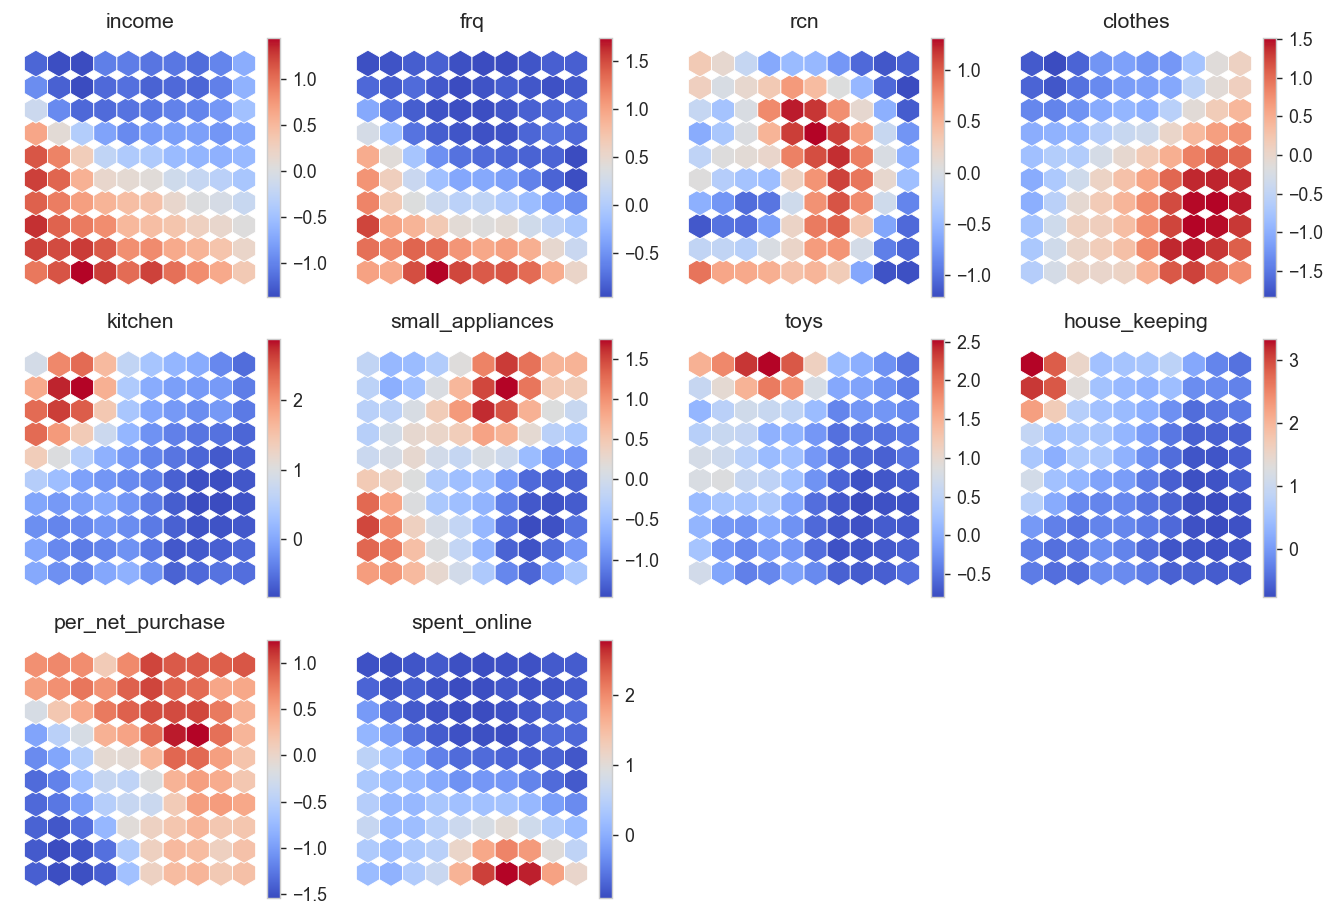

In [26]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

#### What features are relatively uniform ? 

#### Where can you find outliers ? 

#### Two features positively correlated ? And negativly ?

#### What customers segments might exist based on these patterns ? 

.

.

## U-Matrix (Unified Distance Matrix)

Shows average **distance** between each SOM unit and its neighbors

Analyse: 
- Clusters of units 
- Potential outliers 

In [27]:
umatrix = sm.distance_map(scaling='mean')

## Flip and rotate to match plot
print(np.flip(np.round(umatrix,2), axis=1).T)


[[0.9  0.81 0.85 0.94 0.86 0.75 0.64 0.57 0.42 0.38]
 [0.85 0.98 0.92 0.87 0.89 0.74 0.69 0.61 0.52 0.39]
 [1.   0.96 0.92 0.84 0.73 0.71 0.66 0.67 0.58 0.5 ]
 [0.97 0.91 0.86 0.78 0.67 0.63 0.65 0.65 0.59 0.47]
 [0.75 0.78 0.76 0.72 0.69 0.67 0.66 0.63 0.55 0.46]
 [0.75 0.67 0.64 0.64 0.65 0.64 0.61 0.58 0.52 0.44]
 [0.72 0.66 0.6  0.65 0.59 0.6  0.55 0.57 0.56 0.52]
 [0.66 0.6  0.61 0.6  0.68 0.66 0.64 0.66 0.61 0.47]
 [0.61 0.58 0.55 0.63 0.69 0.72 0.76 0.74 0.66 0.51]
 [0.7  0.56 0.51 0.59 0.72 0.8  0.67 0.77 0.69 0.54]]


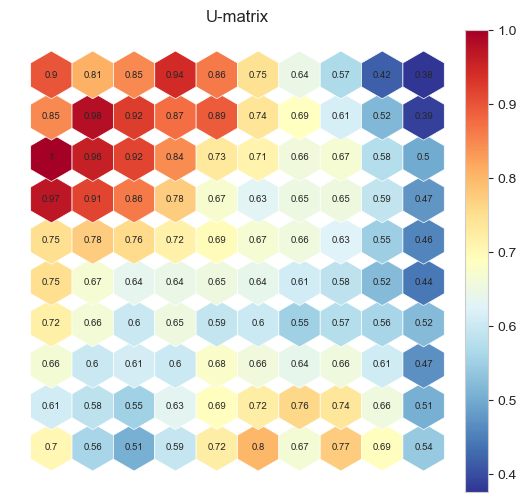

In [28]:
fig = plt.figure(figsize=(9,6))

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

#### How many clusters can you identify ? Characterize them 

#### Where are the potential outliers located ? Characterize them

. 

.

#### Homework 

- Improve the U-matrix visualizationg by marking high distance units
- Suggestion: threshold = u_matrix.mean() + u_matrix.std()

## Hit-map 

Show the **frequency** of each Unit in the output map



In [29]:
hitsmatrix = sm.activation_response(df[metric_features].values)

## Values of HITS:
## Flip and rotate to match plot
np.flip(np.round(hitsmatrix,2), axis=1).T


array([[124.,  53.,  79.,  67., 104., 112.,  73.,  93.,  73.,  84.],
       [ 68.,  60.,  59.,  74., 101.,  69.,  62.,  74.,  56.,  74.],
       [ 26.,  36.,  73.,  94.,  71.,  82.,  96., 110.,  74., 140.],
       [ 68.,  59.,  47.,  69.,  78.,  60.,  96.,  86., 114., 124.],
       [104.,  89., 101.,  72.,  80., 106., 118., 131.,  82.,  79.],
       [131.,  68.,  71.,  69.,  60., 101.,  87., 126.,  74.,  66.],
       [109.,  86.,  69.,  84.,  75., 137.,  61.,  89.,  81., 157.],
       [137.,  69., 120.,  76., 128.,  91.,  83.,  92.,  67.,  94.],
       [ 96.,  63.,  95.,  80.,  95.,  73.,  81.,  77.,  98.,  95.],
       [146., 136., 138., 117.,  94., 113.,  70.,  86., 104.,  78.]])

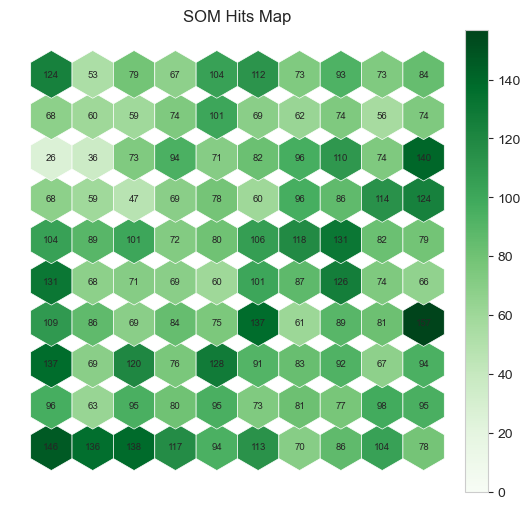

In [30]:
fig = plt.figure(figsize=(9, 6))

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )


#### Are customers evenly distributed across the grid ? Any empty units ? 

#### Which grid positions have the highest customer count ? And the lowest ? 

In [31]:
print(f"Average customers per unit: {hitsmatrix.mean():.1f}")

Average customers per unit: 88.2


In [32]:
print(f"Frequency range: {hitsmatrix.min():.0f} (least) to {hitsmatrix.max():.0f} (most)")

Frequency range: 26 (least) to 157 (most)


#### Homework 

- Identify on the Hit-map customers in the lowest density units 
- Characterize them

. 

.

.

# Two-Stage Clustering with SOM

Use SOM weights as input to a traditional clustering algorithm 

Advantages:
- Computational efficiency
- Pattern preservation

#### Emergent SOM 

A very large number of units is used (eg: 50*50). This allows for very clear U-matirces and is useful for detecting quite clearly the underlying structue of the data. 

Can also be used with other clustering algorithms



In [33]:
M = 20 
N = 30  
neighborhood_function = 'gaussian' 
n_feats = len(metric_features)
learning_rate = .5


som_data = df[metric_features].values

sm = MiniSom(M, N,              
             n_feats,        
             learning_rate=learning_rate, 
             #topology=topology, 
             neighborhood_function=neighborhood_function, 
             sigma=1.8,
             activation_distance='euclidean',
             random_seed=42
             )

#### Homework

Systematically experiment and evaluate how SOM parameters affect quality metrics (QE and TE)

Suggestions 
- Different grid sizes 5x5, 20x20, and emergent SOM with 50x50
- Different learning rates: 0.1, 0.5, 1.0
- Different sigma values: 0.5, 1.0, 2.0


In [34]:
sm.random_weights_init(som_data) 

print(np.round(sm.quantization_error(som_data),4), "Starting QE")
print(np.round(sm.topographic_error(som_data),4), "Starting TE")

1.0719 Starting QE
0.9876 Starting TE


In [35]:
sm.train_batch(som_data, 500_000)


In [36]:

print(np.round(sm.quantization_error(som_data),4),"Ending QE")
print(np.round(sm.topographic_error(som_data),4),"Ending TE")


1.0101 Ending QE
0.1622 Ending TE


In [37]:
weights = sm.get_weights()

weights.shape

(20, 30, 10)

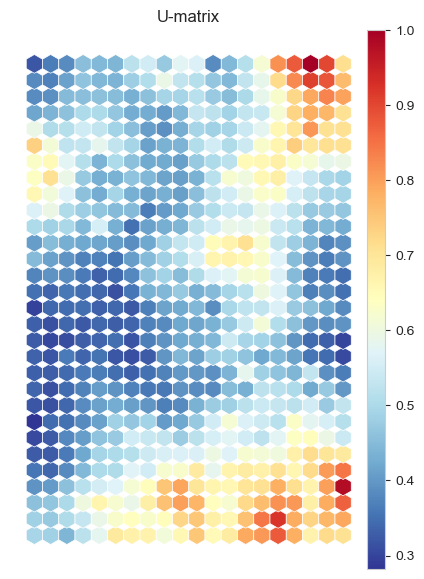

In [38]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )

#### K-means on SOM units

In [39]:
weights_flat = weights.reshape(M * N, len(metric_features))

weights_flat.shape

(600, 10)

In [40]:
weights_df = pd.DataFrame(weights_flat, columns=[metric_features])

weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
0,-1.133277,-0.987210,1.146603,-1.245896,0.200061,1.655412,-0.564784,1.358797,0.788288,-0.893083
1,-1.090421,-0.773410,1.179924,-1.216131,0.094774,2.063849,-0.451954,0.585744,0.804395,-0.746368
2,-0.997622,-0.798143,1.316073,-0.965593,-0.087143,2.088266,-0.311534,-0.170652,0.928232,-0.777367
3,-0.915922,-0.950734,1.378966,-0.619033,-0.398687,1.556373,-0.215011,-0.139989,0.980216,-0.889847
4,-1.051249,-0.963329,1.418596,-0.302718,-0.605421,1.044467,-0.262449,-0.013626,1.247894,-0.927288
...,...,...,...,...,...,...,...,...,...,...
595,0.680996,0.744955,-0.897160,-0.564089,0.203561,-0.385165,2.450296,-0.079048,-0.839281,0.526336
596,0.425017,0.400494,-0.600884,-0.693279,0.302133,-0.621904,2.081449,0.932751,-0.656454,0.358436
597,0.790679,0.526126,-0.238516,-1.147393,-0.182389,-0.258359,2.094485,2.179891,-1.108738,0.098853
598,1.184824,0.854316,0.403690,-1.234679,-0.318629,0.099291,1.157533,2.862119,-1.220122,0.281189


#### How could you choose K for K-means ?

#### Homework

In [41]:
# For demonstration, we'll use K=4 
K = 4 

# Cluster the SOM prototypes (not customers!)
kmeans_som = KMeans(n_clusters=K, random_state=42, n_init=10, init='k-means++')

kmeans_units_labels = kmeans_som.fit_predict(weights_df[metric_features])


In [42]:
weights_df['Kmeans_units_labels'] = kmeans_units_labels
weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,Kmeans_units_labels
0,-1.133277,-0.987210,1.146603,-1.245896,0.200061,1.655412,-0.564784,1.358797,0.788288,-0.893083,3
1,-1.090421,-0.773410,1.179924,-1.216131,0.094774,2.063849,-0.451954,0.585744,0.804395,-0.746368,0
2,-0.997622,-0.798143,1.316073,-0.965593,-0.087143,2.088266,-0.311534,-0.170652,0.928232,-0.777367,0
3,-0.915922,-0.950734,1.378966,-0.619033,-0.398687,1.556373,-0.215011,-0.139989,0.980216,-0.889847,0
4,-1.051249,-0.963329,1.418596,-0.302718,-0.605421,1.044467,-0.262449,-0.013626,1.247894,-0.927288,0
...,...,...,...,...,...,...,...,...,...,...,...
595,0.680996,0.744955,-0.897160,-0.564089,0.203561,-0.385165,2.450296,-0.079048,-0.839281,0.526336,2
596,0.425017,0.400494,-0.600884,-0.693279,0.302133,-0.621904,2.081449,0.932751,-0.656454,0.358436,2
597,0.790679,0.526126,-0.238516,-1.147393,-0.182389,-0.258359,2.094485,2.179891,-1.108738,0.098853,2
598,1.184824,0.854316,0.403690,-1.234679,-0.318629,0.099291,1.157533,2.862119,-1.220122,0.281189,2


In [43]:
weights_df['Kmeans_units_labels'].value_counts().sort_index()

(Kmeans_units_labels,)
0                         191
1                         114
2                         183
3                         112
Name: count, dtype: int64

#### HC on SOM units

##### How to define the best linkage method for HC on SOM units? And the optimal K ? 

##### Homework 

In [44]:
hc_som = AgglomerativeClustering(n_clusters=K, linkage='ward')

hc_units_labels = hc_som.fit_predict(weights_df[metric_features])


In [45]:
weights_df["HC_units_labels"] = hc_units_labels
weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,Kmeans_units_labels,HC_units_labels
0,-1.133277,-0.987210,1.146603,-1.245896,0.200061,1.655412,-0.564784,1.358797,0.788288,-0.893083,3,0
1,-1.090421,-0.773410,1.179924,-1.216131,0.094774,2.063849,-0.451954,0.585744,0.804395,-0.746368,0,0
2,-0.997622,-0.798143,1.316073,-0.965593,-0.087143,2.088266,-0.311534,-0.170652,0.928232,-0.777367,0,0
3,-0.915922,-0.950734,1.378966,-0.619033,-0.398687,1.556373,-0.215011,-0.139989,0.980216,-0.889847,0,0
4,-1.051249,-0.963329,1.418596,-0.302718,-0.605421,1.044467,-0.262449,-0.013626,1.247894,-0.927288,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.680996,0.744955,-0.897160,-0.564089,0.203561,-0.385165,2.450296,-0.079048,-0.839281,0.526336,2,3
596,0.425017,0.400494,-0.600884,-0.693279,0.302133,-0.621904,2.081449,0.932751,-0.656454,0.358436,2,3
597,0.790679,0.526126,-0.238516,-1.147393,-0.182389,-0.258359,2.094485,2.179891,-1.108738,0.098853,2,3
598,1.184824,0.854316,0.403690,-1.234679,-0.318629,0.099291,1.157533,2.862119,-1.220122,0.281189,2,3


In [46]:
weights_df['HC_units_labels'].value_counts().sort_index()

(HC_units_labels,)
0                     162
1                     175
2                     156
3                     107
Name: count, dtype: int64

#### For each customer get their BMU 

In [47]:
# Find BMU for each customer
bmu_indices = []
for customer_vec in som_data:
    bmu = sm.winner(customer_vec)  # Returns (row, col) on SOM grid
    bmu_indices.append(bmu)

bmu_indices = np.array(bmu_indices)
bmu_indices

array([[ 8, 25],
       [ 9, 22],
       [18,  0],
       ...,
       [ 9,  7],
       [14, 21],
       [ 1, 24]])

In [48]:
bmu_indices.shape

(8817, 2)

In [49]:
bmu_flat_indices = [bmu[0] * N + bmu[1] for bmu in bmu_indices]
bmu_flat_indices = np.array(bmu_flat_indices)
bmu_flat_indices


array([265, 292, 540, ..., 277, 441,  54])

In [50]:
bmu_flat_indices.shape

(8817,)

In [51]:
print(f"Minimum BMU flat index: {bmu_flat_indices.min()}")
print(f"Maximum BMU flat index: {bmu_flat_indices.max()}")

Minimum BMU flat index: 0
Maximum BMU flat index: 599


In [52]:
df_final = pd.concat([
                df,
                pd.Series(bmu_flat_indices, name='BMU', index=df.index)
            ], axis=1
            )

df_final

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Single,oh_status_Together,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,BMU
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,265
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,292
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,540
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,260
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,320
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,110
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,277
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,441


#### Map customers BMU to units labels 

In [53]:
df_final['Kmeans_labels'] = df_final['BMU'].map(
    lambda x: kmeans_units_labels[x] )

df_final['HC_labels'] = df_final['BMU'].map(
    lambda x: hc_units_labels[x] )

In [54]:
df_final

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,BMU,Kmeans_labels,HC_labels
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,265,2,3
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,292,2,1
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,540,3,0
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,260,2,1
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,112,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,320,2,1
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,110,1,1
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,277,0,2
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,441,2,1


In [55]:
print(df_final['Kmeans_labels'].value_counts().sort_index())

print(df_final['HC_labels'].value_counts().sort_index())

Kmeans_labels
0    3113
1    1770
2    2511
3    1423
Name: count, dtype: int64
HC_labels
0    2200
1    2539
2    2618
3    1460
Name: count, dtype: int64


In [56]:
r2_kmeans = get_rsq(df_final, metric_features, 'Kmeans_labels')
r2_hc = get_rsq(df_final, metric_features, 'HC_labels')

print(f"R² for K-means clustering on SOM units:     {r2_kmeans:.4f}")
print(f"R² for HC on SOM units:                     {r2_hc:.4f}")

R² for K-means clustering on SOM units:     0.4543
R² for HC on SOM units:                     0.4182


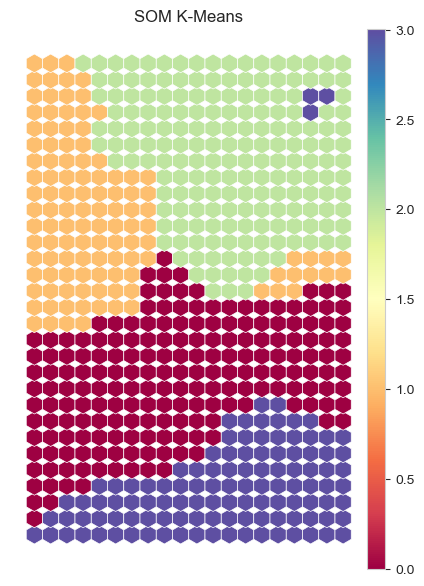

In [57]:
kmeans_matrix = kmeans_units_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )


#### Do the cluster boundaries align with high U-Matrix distances ? 

#### Which clusters have outliers ? 

<Axes: xlabel='Kmeans_labels'>

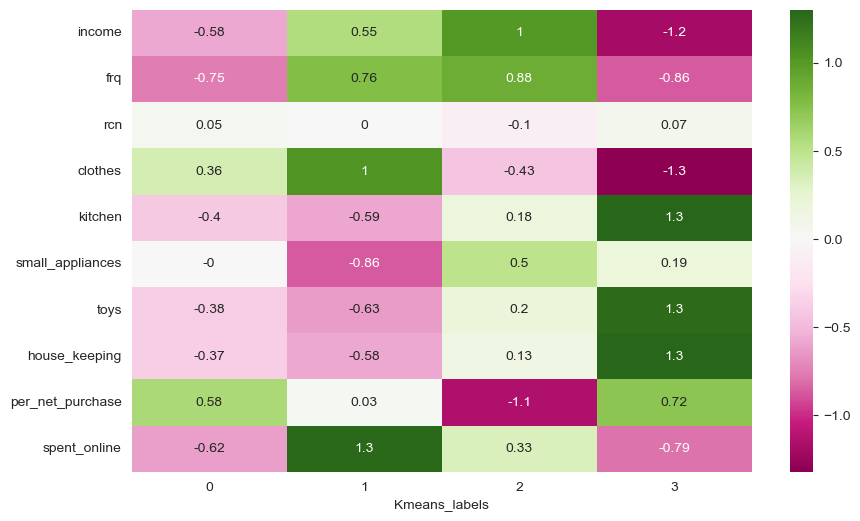

In [58]:
mat = df_final[metric_features + ['Kmeans_labels']].groupby('Kmeans_labels').mean().round(2)

sns.heatmap(mat.T, annot=True, cmap='PiYG', center=0)

#### Do the clusters average correlate with the component observed earlier ?

.

.



## Course Project Transfer

**Apply SOMs to Your Airline Customer Segmentation Project**
